In [1]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import copy 

# CIFAR-10 Import for playing around

In [2]:
MEANS = (0.5, 0.5, 0.5)
STDS = (0.5, 0.5, 0.5)
BATCH_SIZE = 4
IMG_SIZE = (128, 128)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(MEANS, STDS)
    ])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2
    )

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2
    )

classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
    )

Files already downloaded and verified
Files already downloaded and verified


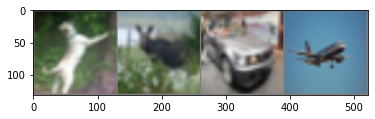

  dog  deer   car plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # unnormalize
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [4]:
print(images.shape, labels.shape)

torch.Size([4, 3, 128, 128]) torch.Size([4])


# D-CONV and S-CONV

In [243]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()

        self.stride = stride 
        self.kernel_size = kernel_size
        self.padding = padding

        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 
                kernel_size=kernel_size, stride=stride, 
                padding=padding, bias=False
                ), 
            nn.BatchNorm2d(out_channels, affine=False), 
            nn.ReLU()
            )

    def forward(self, x):
        out = self.layers(x)
        return out 

    def _calculate_out_dim(self, in_dim):
        """
        in_dim = (in_width, in_height)
        """
        out_width = in_dim[0] + 2 * self.padding - self.kernel_size 
        out_width = int(out_width / self.stride) + 1
        out_height = in_dim[1] + 2 * self.padding - self.kernel_size
        out_height = int(out_height / self.stride) + 1
        return (out_width, out_height)


class FCBlock(nn.Module):
    def __init__(self, in_dim, out_dim, bias=False):
        super(FCBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim, bias=bias), 
            nn.BatchNorm1d(out_dim, affine=False), 
            nn.ReLU()
            )

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.layers(out)
        return out



class SConv(nn.Module):
    def _calculate_out_dim(self):
        return self.conv_layer._calculate_out_dim(self.img_size)

    def __init__(self, in_channels, base_channels, img_size, **kwargs):
        super(SConv, self).__init__()

        self.img_size = img_size
        self.kernel_size = kwargs['kernel_size'] if 'kernel_size' in kwargs else 9
        self.padding = kwargs['padding'] if 'padding' in kwargs else 0
        self.num_classes = kwargs['num_classes'] if 'num_classes' in kwargs else 10

        self.conv_layer = ConvBlock(
            in_channels, base_channels, 
            kernel_size=self.kernel_size, stride=2, padding=self.padding
            )
        
        conv_out_width, conv_out_height = self._calculate_out_dim()
        fc_input_dim = base_channels * conv_out_width * conv_out_height
        
        # First FC is FCBlock (with BN and ReLU) and second just a Linear layer
        self.fc_layers = nn.Sequential(
            FCBlock(fc_input_dim, 24 * base_channels, bias=False), 
            nn.Linear(24 * base_channels, self.num_classes, bias=False)
            )

    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)

        return out 



class DConv(nn.Module):
    def _calculate_out_dim(self):
        out_dim = self.img_size
        for i in range(len(self.conv_layers)):
            out_dim = self.conv_layers[i]._calculate_out_dim(out_dim)

        return out_dim 

    def __init__(self, in_channels, base_channels, img_size, **kwargs):
        super(DConv, self).__init__()
        
        self.img_size = img_size
        self.kernel_size = kwargs['kernel_size'] if 'kernel_size' in kwargs else 3
        self.padding = kwargs['padding'] if 'padding' in kwargs else 0
        self.num_classes = kwargs['num_classes'] if 'num_classes' in kwargs else 10

        self.conv_layers = nn.ModuleList()

        # First layer - (alpha, 1)
        # in_channels -> base_channels
        self.conv_layers.append(
            ConvBlock(
                in_channels, base_channels, 
                kernel_size=self.kernel_size, stride=1, padding=self.padding
                )
            )

        num_block_pairs = 3
        scales = [2**i for i in range(num_block_pairs + 2)]
        channels_per_layer = [scale * base_channels for scale in scales]
        for i in range(len(channels_per_layer) - 2):
            # base_channels, 2 * base_channels, 4 * base_channels
            curr_in_channels = channels_per_layer[i]
            # 2 * base_channels, 4 * base_channels, 8 * base_channels
            curr_out_channels = channels_per_layer[i + 1]
            
            # Even block - (scale * alpha, 2)
            self.conv_layers.append(
                ConvBlock(
                    curr_in_channels, curr_out_channels, 
                    kernel_size=self.kernel_size, stride=2, padding=self.padding
                    )
                )
            
            # Odd block - (scale * alpha, 1)
            self.conv_layers.append(
                ConvBlock(
                    curr_out_channels, curr_out_channels, 
                    kernel_size=self.kernel_size, stride=1, padding=self.padding
                    )
                )

        self.conv_layers.append(
            ConvBlock(
                scales[-2] * base_channels, scales[-1] * base_channels, 
                kernel_size=self.kernel_size, stride=2, padding=self.padding
                )
            )

        conv_out_width, conv_out_height = self._calculate_out_dim()
        fc_input_dim = 16 * base_channels * conv_out_width * conv_out_height
        
        self.fc_layers = nn.Sequential(
            FCBlock(fc_input_dim, 64 * base_channels),
            nn.Linear(64 * base_channels, self.num_classes, bias=False)
            )


    def forward(self, x):
        out = copy.deepcopy(x)
        for i in range(len(self.conv_layers)):
            out = self.conv_layers[i](out)

        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)

        return out 


In [244]:
ALPHA = 1
NUM_CLASSES = 10
IN_CHANNELS = 3

d_conv = DConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES)
s_conv = SConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES)

# d_conv
# s_conv

In [245]:
out_d = d_conv(images)
out_s = s_conv(images)

print(out_d.shape)
print(out_s.shape)


torch.Size([4, 10])
torch.Size([4, 10])


## Parameter count - Padding discussion


In [275]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_true_parameters_count(model, alpha, img_size, num_classes):
    if model == 'D-CONV':
        cnt = (9 * 2**8 + 4 * img_size[0]**2) * alpha**2 
        cnt += (27 + 64 * num_classes) * alpha 
    
    elif model == 'S-CONV':
        cnt = 6 * img_size[0]**2 * alpha**2 + (243 + 24 * num_classes) * alpha
    
    elif model == 'D-FC':
        cnt = (img_size[0]**4 + 4 * img_size[0]**2) * alpha**2
        cnt += (3 * img_size[0]**4 + 64 * num_classes) * alpha

    elif model == 'S-FC':
        cnt = 6 * img_size[0]**2 * alpha**2 
        cnt += (3 * img_size[0]**4 / 4 + 24 * num_classes) * alpha

    return cnt 
    


In [247]:
print('Without padding - NO MATCH \n')
print(get_true_parameters_count('D-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_conv), '\n')

print(get_true_parameters_count('S-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_conv), '\n')

print('Padding: D-1, S-4 - MATCH \n')
d_conv = DConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=1)
s_conv = SConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=4)

print(get_true_parameters_count('D-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_conv), '\n')

print(get_true_parameters_count('S-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_conv), '\n')


Without padding - NO MATCH 

68507
28553 

98787
86883 

Padding: D-1, S-4 - MATCH 

68507
68489 

98787
98787 



### Recreating Table 3 and Table 4, row 1

In [241]:
for i in range(len(d_conv.conv_layers)):
    cnt = count_parameters(d_conv.conv_layers[i].layers)
    print(f'9 x {cnt // 9 // ALPHA} x {ALPHA}')

cnt = count_parameters(d_conv.fc_layers[0])
print(f'4 x {int((cnt // 4 // ALPHA**2) ** 0.5)}^2 x {ALPHA**2}')

cnt = count_parameters(d_conv.fc_layers[1])
print(f'{cnt // ALPHA // NUM_CLASSES} x {NUM_CLASSES} x {ALPHA}')


9 x 3 x 1
9 x 2 x 1
9 x 4 x 1
9 x 8 x 1
9 x 16 x 1
9 x 32 x 1
9 x 64 x 1
9 x 128 x 1
4 x 128^2 x 1
64 x 10 x 1


In [242]:
cnt = count_parameters(s_conv.conv_layer)
print(f'81 x {cnt // 81 // ALPHA} x {ALPHA}')

cnt = count_parameters(s_conv.fc_layers[0])
print(f'6 x {int((cnt // 6 // ALPHA**2) ** 0.5)}^2 x {ALPHA**2}')

cnt = count_parameters(s_conv.fc_layers[1])
print(f'{cnt // ALPHA // NUM_CLASSES} x {NUM_CLASSES} x {ALPHA}')


81 x 3 x 1
6 x 128^2 x 1
24 x 10 x 1


# D-FC and S-FC

In [272]:
class DFC(nn.Module):
    def __init__(self, in_channels, base_channels, img_size, num_classes):
        super(DFC, self).__init__()

        self.img_size = img_size
        self.num_classes = num_classes

        self.fc_layers = nn.ModuleList()

        img_dim = img_size[0] * img_size[1]
        self.fc_layers.append(
            FCBlock(in_channels * img_dim, base_channels * img_dim)
            )

        num_block_pairs = 3
        scales = [2**(-i) for i in range(num_block_pairs + 2)]
        dim_per_layer = [int(scale * base_channels * img_dim) for scale in scales]
        for i in range(len(dim_per_layer) - 2):
            curr_in_dim, curr_out_dim = dim_per_layer[i], dim_per_layer[i + 1]

            # Even block
            self.fc_layers.append(FCBlock(curr_in_dim, curr_out_dim))
            
            # Odd block - (scale * alpha, 1)
            self.fc_layers.append(FCBlock(curr_out_dim, curr_out_dim))

        self.fc_layers.append(FCBlock(dim_per_layer[-2], dim_per_layer[-1]))
            
        # Last two layers
        self.fc_layers.append(
            nn.Sequential(
                FCBlock(dim_per_layer[-1], 64 * base_channels),
                nn.Linear(64 * base_channels, num_classes, bias=False)
                )
            )

    def forward(self, x):
        out = x.view(x.size(0), -1)
        for i in range(len(self.fc_layers)):
            out = self.fc_layers[i](out)

        return out
                    
        

class SFC(nn.Module):
    def __init__(self, in_channels, base_channels, img_size, num_classes):
        super(SFC, self).__init__()

        self.img_size = img_size
        self.num_classes = num_classes

        self.fc_layers = nn.ModuleList()

        img_dim = img_size[0] * img_size[1]
        self.fc_layers.append(
            FCBlock(in_channels * img_dim, int(base_channels / 4 * img_dim))
            )
        
        # Last two layers
        self.fc_layers.append(
            nn.Sequential(
                FCBlock(int(base_channels / 4 * img_dim), 64 * base_channels),
                nn.Linear(64 * base_channels, num_classes, bias=False)
                )
            )

    def forward(self, x):
        out = x.view(x.size(0), -1)
        for i in range(len(self.fc_layers)):
            out = self.fc_layers[i](out)

        return out



In [273]:
s_fc = SFC(IN_CHANNELS, ALPHA, IMG_SIZE, NUM_CLASSES)
d_fc = DFC(IN_CHANNELS, ALPHA, IMG_SIZE, NUM_CLASSES)

# d_fc

In [274]:
out_fc_d = d_fc(images)
out_fc_s = s_fc(images)

print(out_fc_d.shape)
print(out_fc_s.shape)

torch.Size([4, 10])
torch.Size([4, 10])


## Parameter count

In [277]:
print(get_true_parameters_count('S-FC', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_fc), '\n')

print(get_true_parameters_count('D-FC', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_fc))


201425136.0
201589376 

1073808000
1071710848


### Recreating Table 3 and Table 4, row 3

In [287]:
s_quad = IMG_SIZE[0] ** 4
cnt = count_parameters(d_fc.fc_layers[0].layers)
print(f'3 x {int((cnt // 3 // ALPHA)**0.25)}^4 x {ALPHA}')

for i in range(1, len(d_fc.fc_layers) - 1):
    cnt = count_parameters(d_fc.fc_layers[i].layers)
    print(f'{IMG_SIZE[0]}^4 x {ALPHA}^2 / {int(s_quad // cnt // ALPHA**2)}')

cnt = count_parameters(d_fc.fc_layers[-1][0].layers)
print(f'4 x {int((cnt // 4 // ALPHA**2) ** 0.5)}^2 x {ALPHA**2}')

cnt = count_parameters(d_fc.fc_layers[-1][1])
print(f'64 x {int(cnt // 64 // ALPHA)} x {ALPHA}')




3 x 128^4 x 1
128^4 x 1^2 / 2
128^4 x 1^2 / 4
128^4 x 1^2 / 8
128^4 x 1^2 / 16
128^4 x 1^2 / 32
128^4 x 1^2 / 64
128^4 x 1^2 / 128
4 x 128^2 x 1
64 x 10 x 1
